# Neural Machine Translation with Seq2Seq

Links to pairwise translation datasets
http://www.manythings.org/anki/


In [52]:
import os, sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model, Sequence

import numpy as np
import matplotlib.pyplot as plt

In [53]:
# set parameter values
BATCH_SIZE = 32
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

# too short sentences
NUM_SHORT = 4

### Data Preprocessing
Neural machine translation models are often based on the seq2seq architecture. The seq2seq architecture is an encoder-decoder architecture which consists of two LSTM networks: the encoder LSTM and the decoder LSTM. The input to the encoder LSTM is the sentence in the original language; the input to the decoder LSTM is the sentence in the translated language with a start-of-sentence token. The output is the actual target sentence with an end-of-sentence token.

In our dataset, we do not need to process the input, however, we need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token. On each line, the text file contains an English sentence and its French translation, separated by a tab.

In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'data/fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')[:2]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

In [8]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [9]:
# print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

Beat it.
Pars ! <eos>
<sos> Pars !


#### Tokenization

The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.
For tokenization, the Tokenizer class from the tensorflow.keras.preprocessing.text library can be used. The tokenizer class performs two tasks:
    - It divides a sentence into the corresponding list of word  
    - Then it converts the words to integers  
This is extremely important since deep learning and machine learning algorithms work with numbers.

In addition to tokenization and integer conversion, the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

In [13]:
#input sequence tokenisation
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

In [11]:
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

Total unique words in the input: 3449


In [12]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Length of longest sentence in input: 5


In [14]:
# Output sequence tokenization
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [15]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 9543


In [16]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 12


From the comparison of the number of unique words in the input and the output, it can be concluded that English sentences are normally shorter and contain a smaller number of words on average, compared to the translated French sentences

#### Padding
We pad the sentences because they are of varying length, however LSTM (the algorithm that we are going to train our model) expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

We use the length of the longest sentence in the inputs and outputs to determine the padding length, respectively. If the longest sentence in the input contains 6 words. For the sentences that contain less than 6 words, zeros will be added in the empty indexes. The following script applies padding to the input sentences.

In [17]:
# defines the encoder input dimension
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)

encoder_input_sequences.shape: (20000, 5)


Since there are 20,000 sentences in the input and each input sentence is of length 5, the shape of the input is now (20000, 5)

In [18]:
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences[172]: [  0   0   0 304   4]


In [19]:
# verify that the integer values for some examples
print(word2idx_inputs["i'm"])
print(word2idx_inputs["ill"])

7
535


In [20]:
# define the decoders input diemnsion
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)

decoder_input_sequences.shape: (20000, 12)


In [21]:
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences[172]: [  2 370   4   0   0   0   0   0   0   0   0   0]


In [22]:
# print the corresponding integers from the word2idx_outputs dictionary,
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["je"])
print(word2idx_outputs["suis"])
print(word2idx_outputs["malade."])

2
3
7
197


NB: In the case of the decoder, the post-padding is applied, which means that zeros are appended at the end of the sentence. In the encoder, zeros were padded at the beginning. The reason behind this approach is that encoder output is based on the words occurring at the end of the sentence, therefore the original words were kept at the end of the sentence and zeros were padded at the beginning. On the other hand, in the case of the decoder, the processing starts from the beginning of a sentence, and therefore post-padding is performed on the decoder inputs and outputs.

#### Word Embeddings  
For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

In [23]:
embeddings_dictionary = dict()

glove_file = r'glove.6B.100d.txt'
glove_file = open(glove_file, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 3523 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [24]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
# print embedding of ill
print(embeddings_dictionary["ill"])

[ 0.12648    0.1366     0.22192   -0.025204  -0.7197     0.66147
  0.48509    0.057223   0.13829   -0.26375   -0.23647    0.74349
  0.46737   -0.462      0.20031   -0.26302    0.093948  -0.61756
 -0.28213    0.1353     0.28213    0.21813    0.16418    0.22547
 -0.98945    0.29624   -0.62476   -0.29535    0.21534    0.92274
  0.38388    0.55744   -0.14628   -0.15674   -0.51941    0.25629
 -0.0079678  0.12998   -0.029192   0.20868   -0.55127    0.075353
  0.44746   -0.71046    0.75562    0.010378   0.095229   0.16673
  0.22073   -0.46562   -0.10199   -0.80386    0.45162    0.45183
  0.19869   -1.6571     0.7584    -0.40298    0.82426   -0.386
  0.0039546  0.61318    0.02701   -0.3308    -0.095652  -0.082164
  0.7858     0.13394   -0.32715   -0.31371   -0.20247   -0.73001
 -0.49343    0.56445    0.61038    0.36777   -0.070182   0.44859
 -0.61774   -0.18849    0.65592    0.44797   -0.10469    0.62512
 -1.9474    -0.60622    0.073874   0.50013   -1.1278    -0.42066
 -0.37322   -0.50538    0

### Model
Define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output are 9562. Therefore, each word in the output can be any of the 9562 words. The length of an output sentence is 13. And for each input sentence, we need a corresponding output sentence.  
_(number of inputs, length of the output sentence, the number of words in the output)_


In [ ]:
# create the embedding layer for the input
embedding_layer = Embedding(num_words, 
                            EMBEDDING_SIZE, 
                            weights=[embedding_matrix], 
                            input_length=max_input_len)

In [27]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [28]:
# print shape of decoder
decoder_targets_one_hot.shape

(20000, 12, 150)
[[2000, :], [12, :] [150: ]]

(20000, 12, 9544)

The final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word.

In [29]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [30]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [31]:
# Create the encoder and decoders. 
# The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [32]:
# The next step is to define the decoder. 
# The decoder will have two inputs: 
#   the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [33]:
# Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [34]:
# compile the model:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# plot our model :
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


From the output, you can see that we have two types of input. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm_1 layer, which basically is the encoder LSTM. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

Here the lstm_2 layer is the decoder LSTM. The input_2 contains the output sentences with <sos> token appended at the start. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_2. Finally, the output from the decoder LSTM is passed through the dense layer to make predictions

In [ ]:
# # fit the model
# r = model.fit(
#     [encoder_input_sequences, decoder_input_sequences],
#     decoder_targets_one_hot,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_split=0.1,
# )

In [57]:
# fit the model: disable GPU to run on cpu only
with tf.device('/cpu:0'):
    r = model.fit(
        [encoder_input_sequences, decoder_input_sequences],
        decoder_targets_one_hot,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )

Epoch 1/20
563/563 [==============================] - 60s 102ms/step - loss: 1.8811 - accuracy: 0.7365 - val_loss: 1.9768 - val_accuracy: 0.7164
Epoch 2/20
563/563 [==============================] - 68s 120ms/step - loss: 1.4160 - accuracy: 0.7948 - val_loss: 1.7770 - val_accuracy: 0.7466
Epoch 3/20
563/563 [==============================] - 70s 124ms/step - loss: 1.2656 - accuracy: 0.8162 - val_loss: 1.6728 - val_accuracy: 0.7642
Epoch 4/20
563/563 [==============================] - 63s 108ms/step - loss: 1.1700 - accuracy: 0.8290 - val_loss: 1.6263 - val_accuracy: 0.7688
Epoch 5/20
563/563 [==============================] - 57s 101ms/step - loss: 1.0975 - accuracy: 0.8381 - val_loss: 1.6089 - val_accuracy: 0.7667
Epoch 6/20
408/563 [====================>.........] - ETA: 41s - loss: 1.0382 - accuracy: 0.8459

##### The encoder model remains the same

In [44]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

# Since now at each step we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell states as shown below:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [45]:
# Now at each time step, there will be only single word in the decoder input, we need to modify the decoder embedding layer as follows:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [46]:
# Next, we need to create the placeholder for decoder outputs:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [47]:
# To make predictions, the decoder output is passed through the dense layer:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [48]:
# The final step is to define the updated decoder model, as shown here:

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

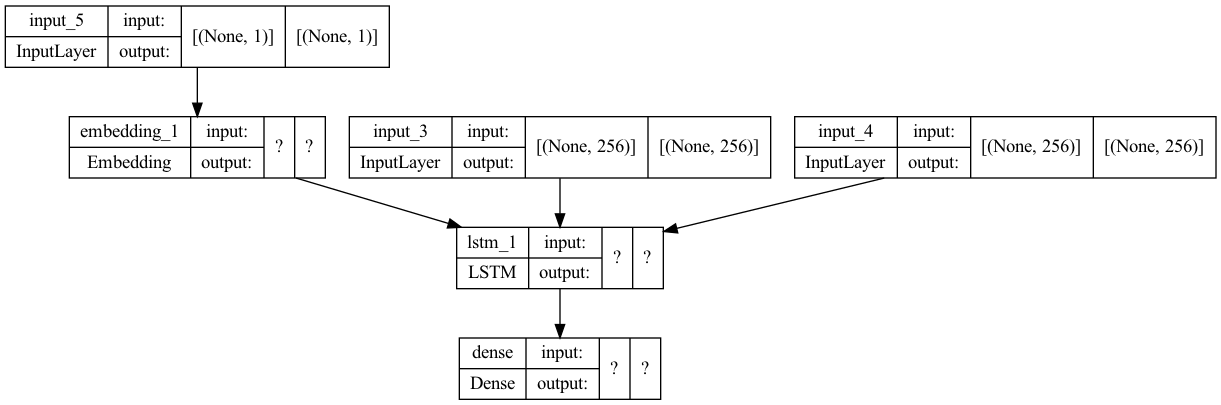

In [49]:
# Let's now plot our modified decoder LSTM that makes predictions:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)


In the image above lstm_2 is the modified decoder LSTM. You can see that it accepts the sentence with with one word as shown in input_5, and the hidden and cell states from the previous output (input_3 and input_4). You can see that the shape of the of the input sentence is now (none,1) since there will be only one word in the decoder input. On the contrary, during training the shape of the input sentence was (None,6) since the input contained a complete sentence with a maximum length of 6.

#### Making Predictions
In this step, you will see how to make predictions using English sentences as inputs.
In the tokenization steps, we converted words to integers. The outputs from the decoder will also be integers. However, we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [51]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [50]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)

In [ ]:
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)